# CIFAR-10 Image Classification with CNN

## Project Overview
Building a Convolutional Neural Network to classify 32x32 color images into 10 categories.
Comparing baseline CNN vs augmented training vs transfer learning.

## Dataset
- 60,000 images (50K train, 10K test)
- 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
- Image size: 32x32x3 (RGB)

In [1]:
# Fix for RTX 5080 Blackwell architecture incompatibility
# Force TensorFlow to use CPU until CUDA compatibility is resolved
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Disable GPU

import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU devices: {tf.config.list_physical_devices('GPU')}")
print("Running on CPU only (RTX 5080 requires CUDA 13+ / TensorFlow nightly)")

2026-01-13 19:46:07.710513: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-13 19:46:07.740720: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-13 19:46:08.440292: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/fabio/Projects/MachineLearning/CNN_image_classifier/v

TensorFlow version: 2.20.0
GPU devices: []
Running on CPU only (RTX 5080 requires CUDA 13+ / TensorFlow nightly)


2026-01-13 19:46:09.229830: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2026-01-13 19:46:09.229848: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:160] env: CUDA_VISIBLE_DEVICES="-1"
2026-01-13 19:46:09.229851: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2026-01-13 19:46:09.229853: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2026-01-13 19:46:09.229855: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: pop-os
2026-01-13 19:46:09.229856: I external/local_xla/xla/stream_executor/cuda/cuda_d

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

/home/fabio/Projects/MachineLearning/CNN_image_classifier/venv/lib/python3.12/site-packages/keras/src/datasets/cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


In [4]:
print(x_train.shape, x_test.shape,
y_train.shape, y_test.shape,
x_train.dtype, 
x_train.min(), x_train.max())

(50000, 32, 32, 3) (10000, 32, 32, 3) (50000, 1) (10000, 1) uint8 0 255


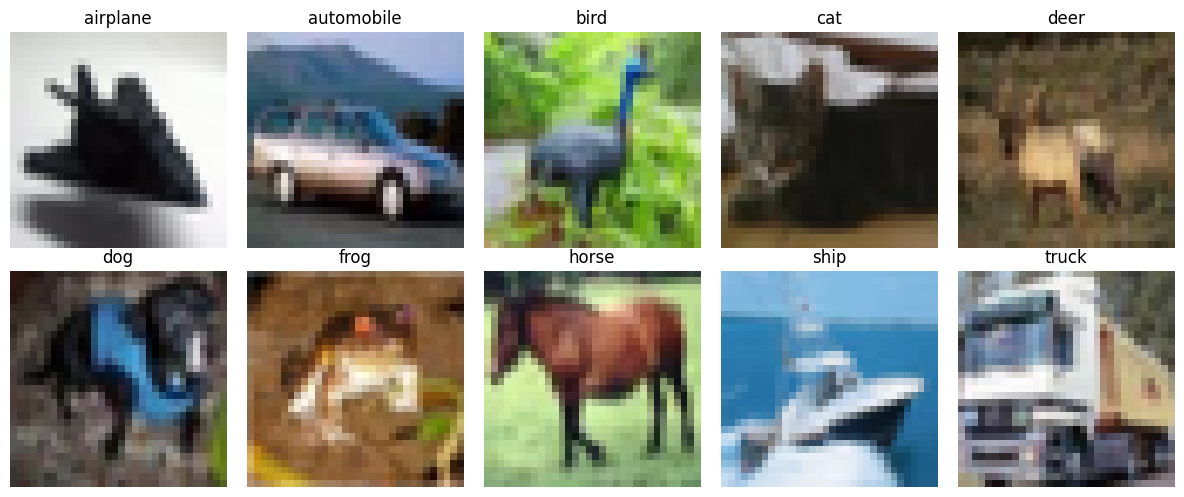

In [5]:
classes = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

plt.figure(figsize=(12,5))
for i, class_name in classes.items():
    index = np.where(y_train[:,0] == i)[0][0]
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[index])
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/sample_per_cass.png')
plt.show()        

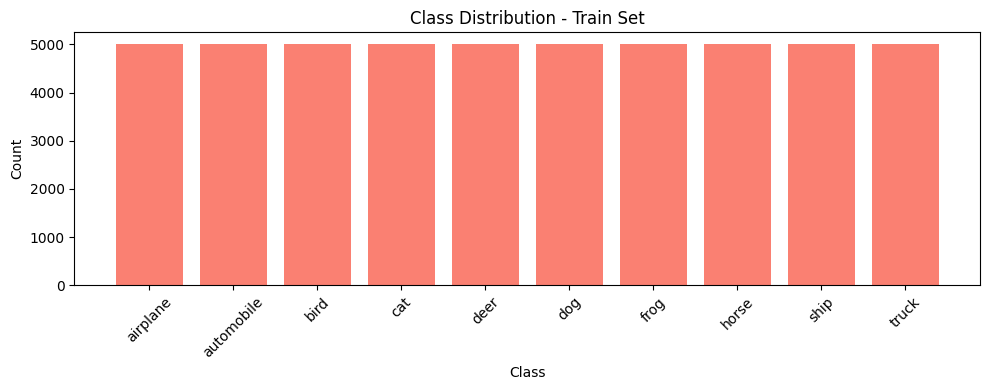

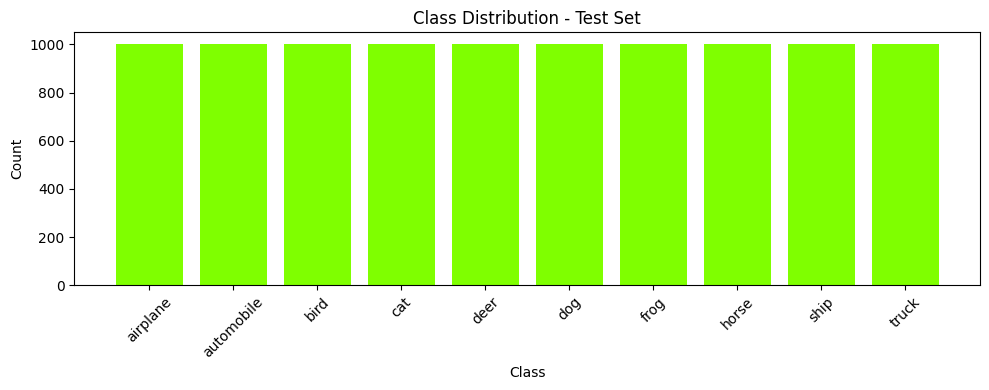

Train: [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000] - Total: 50000
Test: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000] - Total: 10000


In [6]:
# Class distribution - Train Set
train_class_counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(list(classes.values()), train_class_counts[1], color='salmon')
plt.xticks(rotation=45)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution - Train Set')
plt.tight_layout()
plt.savefig('figures/class_distribution_train.png')
plt.show()

# Class distribution - Test Set
test_class_counts = np.unique(y_test, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(list(classes.values()), test_class_counts[1], color='chartreuse')
plt.xticks(rotation=45)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution - Test Set')
plt.tight_layout()
plt.savefig('figures/class_distribution_test.png')
plt.show()

print(f"Train: {train_class_counts[1]} - Total: {train_class_counts[1].sum()}")
print(f"Test: {test_class_counts[1]} - Total: {test_class_counts[1].sum()}")

Red: mean=125.31, std=62.99
Green: mean=122.95, std=62.09
Blue: mean=113.87, std=66.70


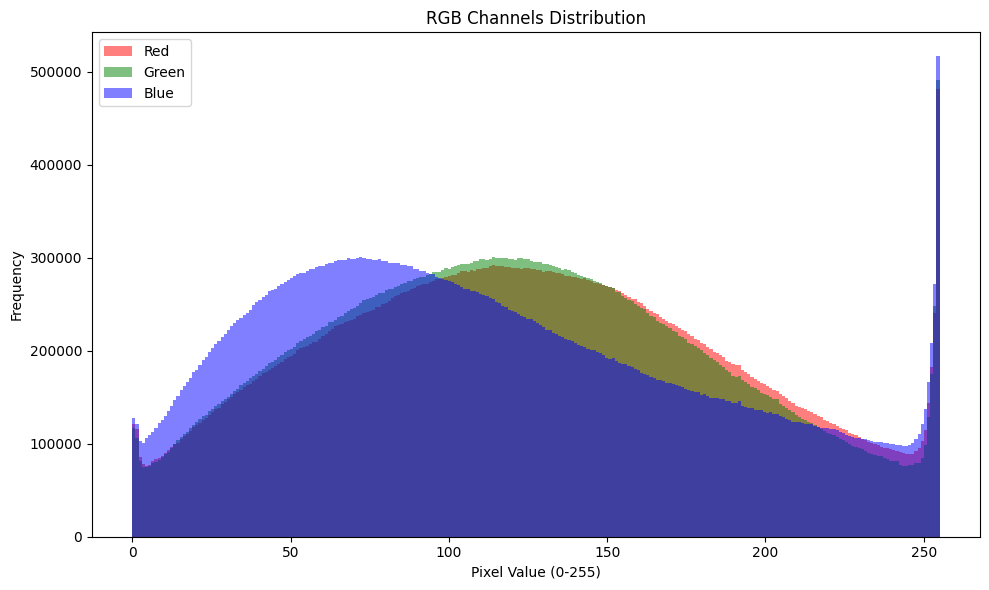

In [7]:
avg_per_channel = x_train.mean(axis=(0,1,2))
std_per_channel = x_train.std(axis=(0,1,2))

print(f"Red: mean={avg_per_channel[0]:.2f}, std={std_per_channel[0]:.2f}")
print(f"Green: mean={avg_per_channel[1]:.2f}, std={std_per_channel[1]:.2f}")
print(f"Blue: mean={avg_per_channel[2]:.2f}, std={std_per_channel[2]:.2f}")

# Visualize histogram
plt.figure(figsize=(10,6))
red_channel = x_train[:, :, :, 0].flatten()
green_channel = x_train[:, :, :, 1].flatten()
blue_channel = x_train[:, :, :, 2].flatten()

plt.hist(red_channel, bins=256, color='red', label='Red', alpha=0.5)
plt.hist(green_channel, bins=256, color='green', label='Green', alpha=0.5)
plt.hist(blue_channel, bins=256, color='blue', label='Blue', alpha=0.5)
plt.legend()
plt.title("RGB Channels Distribution")
plt.xlabel("Pixel Value (0-255)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("figures/channels_distribution.png")
plt.show()

## EDA Summary

### Dataset Overview
- **Total images**: 60,000 (50K train, 10K test)
- **Image size**: 32x32x3 (RGB)
- **Classes**: 10 balanced classes (5000 train, 1000 test each)
- **Data type**: uint8 (0-255)

### Key Findings
1. **Balanced dataset**: Equal distribution across all 10 classes
2. **RGB Statistics**:
   - Red: mean=125.31, std=62.99
   - Green: mean=122.95, std=62.09
   - Blue: mean=113.87, std=66.70
3. **No significant color bias**: Channels have similar distributions
4. **Pixel saturation**: Peaks at 0 and 255 indicate presence of very dark/bright regions

### Preprocessing Implications
- Normalization needed (0-255 → 0-1)
- Per-channel standardization possible using computed mean/std
- Data augmentation recommended for better generalization

In [8]:
## Preprocessing

# Normalization
x_train = x_train.astype('float32') / 255.0 # converto to float
x_test = x_test.astype('float32') / 255.0

# Verify
print(f"x_train dtype: {x_train.dtype}")
print(f"x_train min: {x_train.min()}, max: {x_train.max()}")
print(f"x_test min: {x_test.min()}, max: {x_test.max()}")

x_train dtype: float32
x_train min: 0.0, max: 1.0
x_test min: 0.0, max: 1.0


In [9]:
import sklearn
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size = 0.2, random_state=42
)

# compute mean/std by channel on train set
train_mean = x_train.mean(axis=(0,1,2))
train_std = x_train.std((0,1,2))

# standardization function
def standardize_image(x, mean, std):
    return (x - mean) / std

# apply standardization
x_train = standardize_image(x_train, train_mean, train_std)
x_val = standardize_image(x_val, train_mean, train_std)
x_test = standardize_image(x_test, train_mean, train_std)

In [10]:
# Apply one-hot encoding to target value
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}, y_val: {y_val.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

x_train: (40000, 32, 32, 3), y_train: (40000, 10)
x_val: (10000, 32, 32, 3), y_val: (10000, 10)
x_test: (10000, 32, 32, 3), y_test: (10000, 10)


In [11]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    # Block 1
    layers.Input(shape=(32,32,3)),
    layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.25),

    # Classifier
    layers.Flatten(),
    layers.Dense(units=512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=10, activation='softmax'),
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,168,362 (8.27 MB)

 Trainable params: 2,168,362 (8.27 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Model Compile and training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Save model
os.makedirs('models', exist_ok=True)
model_checkpoint = ModelCheckpoint(
    'models/best_baseline.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    epochs = 20,
    batch_size = 64,
    validation_data= (x_val, y_val),
    callbacks = [early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3687 - loss: 1.7260
Epoch 1: val_accuracy improved from None to 0.61410, saving model to models/best_baseline.keras

Epoch 1: finished saving model to models/best_baseline.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4623 - loss: 1.4795 - val_accuracy: 0.6141 - val_loss: 1.0745 - learning_rate: 0.0010
Epoch 2/20
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6095 - loss: 1.0999
Epoch 2: val_accuracy improved from 0.61410 to 0.67650, saving model to models/best_baseline.keras

Epoch 2: finished saving model to models/best_baseline.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6249 - loss: 1.0632 - val_accuracy: 0.6765 - val_loss: 0.9139 - learning_rate: 0.0010
Epoch 3/20
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6791 - loss: 0.9058
Epoch 3: val_accuracy improved from 0.67650 to 0.72720, saving model to models/best_baseline.keras

Epoch 3: finished saving model to models

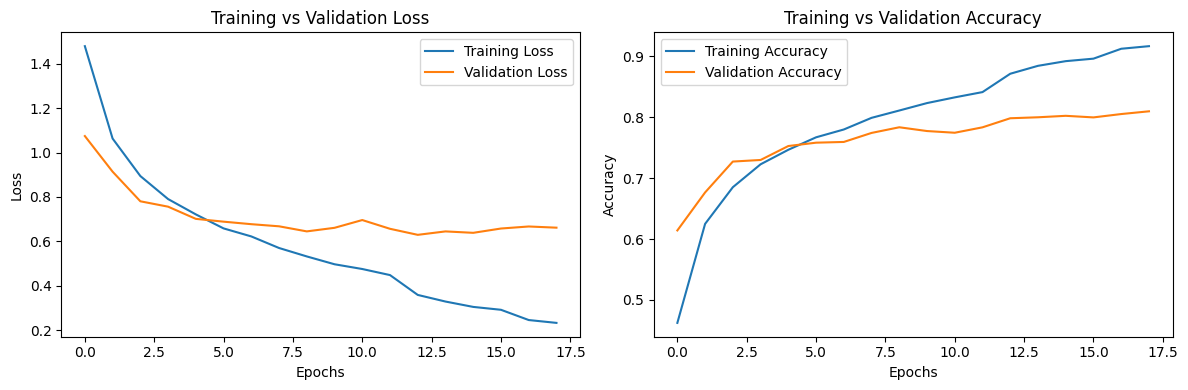

In [13]:
# Plotting training curves

fig, axes = plt.subplots(1,2, figsize=(12,4))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs Validation Loss')
axes[0].legend()

# Accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training vs Validation Accuracy')
axes[1].legend()

# Save model
plt.tight_layout()
plt.savefig('figures/baseline_training_curves.png')
plt.show()

## Baseline Model Results

### Performance
- **Best Validation Accuracy**: 80.7% (epoch 16)
- **Training Accuracy**: ~91%
- **Overfitting Gap**: ~10%

### Observations
1. Clear overfitting: training loss decreases while validation loss increases after epoch 11
2. EarlyStopping triggered at epoch 16, restored weights from epoch 11
3. ReduceLROnPlateau helped temporarily but couldn't prevent overfitting

### Next Steps
- **Data Augmentation**: increase training data variety to reduce overfitting
- **Regularization**: consider stronger dropout or L2 regularization
- **Batch Normalization**: stabilize training and potentially improve generalization

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7909 - loss: 0.6604
Test accuracy: 0.7909
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

    airplane       0.83      0.83      0.83      1000
  automobile       0.86      0.93      0.89      1000
        bird       0.73      0.69      0.71      1000
         cat       0.60      0.60      0.60      1000
        deer       0.79      0.72      0.75      1000
         dog       0.69      0.70      0.69      1000
        frog       0.81      0.87      0.84      1000
       horse       0.81      0.86      0.84      1000
        ship       0.90      0.89      0.89      1000
       truck       0.90      0.83      0.86      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



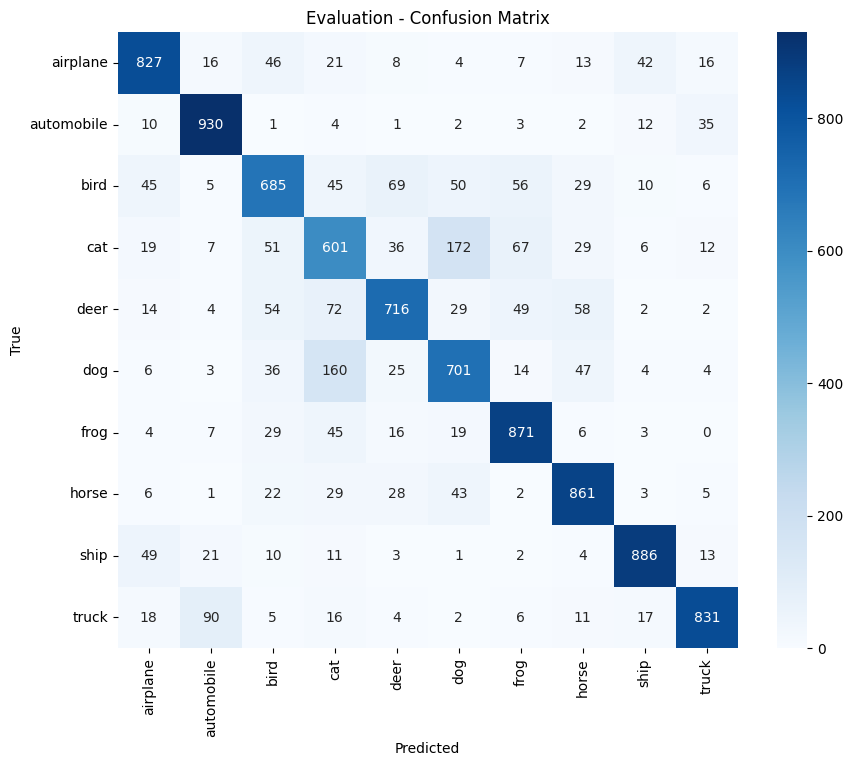

In [14]:
# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(true_classes, predicted_classes, target_names=list(classes.values())))


# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(classes.values()), yticklabels=list(classes.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Evaluation - Confusion Matrix')

plt.savefig('figures/confusion_matrix.png')

baseline_metrics = {
    'test_accuracy': test_acc,
    'test_loss': test_loss,
    'classification_report': classification_report(true_classes, predicted_classes, target_names=list(classes.values()), output_dict=True)    
}

In [15]:
# Save as json
import json

with open('models/baseline_metrics.json', 'w') as f:
    json.dump(baseline_metrics, f, indent=2)

print("Baseline metrics saved!")

Baseline metrics saved!


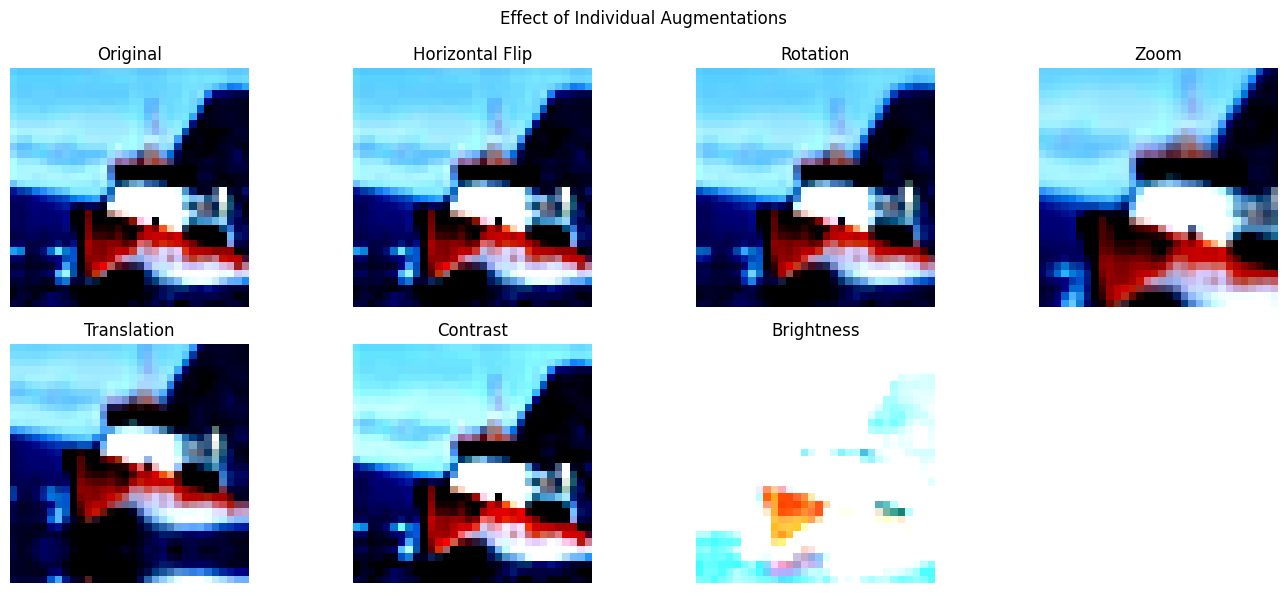

In [16]:
# Mostra effetto di ogni singola trasformazione
single_transforms = {
    'Original': None,
    'Horizontal Flip': layers.RandomFlip('horizontal'),
    'Rotation': layers.RandomRotation(0.1),
    'Zoom': layers.RandomZoom(0.3),
    'Translation': layers.RandomTranslation(0.2, 0.2),
    'Contrast': layers.RandomContrast(0.3),
    'Brightness': layers.RandomBrightness(0.1),
}

image = x_train[1500]
plt.figure(figsize=(14, 6))

for i, (name, transform) in enumerate(single_transforms.items()):
    plt.subplot(2, 4, i + 1)
    if transform is None:
        plt.imshow(np.clip(image, 0, 1))
    else:
        aug = transform(np.expand_dims(image, axis=0), training=True)
        plt.imshow(np.clip(aug[0], 0, 1))
    plt.axis('off')
    plt.title(name)

plt.suptitle('Effect of Individual Augmentations')
plt.tight_layout()
plt.savefig('figures/individual_augmentations.png')
plt.show()

In [17]:
from tensorflow.keras.layers import BatchNormalization, Activation

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.0125),
    layers.RandomZoom(0.0125),
    layers.RandomTranslation(0.0125, 0.0125),
    layers.RandomContrast(0.005)
])

model_augmented = keras.Sequential([
    # Input layer
    layers.Input(shape=(32,32,3)),
    
    # Data Augmentation
    data_augmentation,
    
    # Block 1
    layers.Conv2D(32, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(32, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2),
    layers.Dropout(0.25),
    
    # Block 2
    layers.Conv2D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2),
    layers.Dropout(0.25),
    
    # Classifier
    layers.Flatten(),
    layers.Dense(512),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax'),
])

# Compile
model_augmented.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fresh callbacks
early_stopping_aug = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint_aug = ModelCheckpoint(
    'models/best_augmented.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr_aug = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,  
    min_lr=1e-6,
    verbose=1
)

# Retrain
history_aug = model_augmented.fit(
    x_train, y_train,
    epochs=200,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping_aug, model_checkpoint_aug, reduce_lr_aug]
)

Epoch 1/200
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3375 - loss: 1.9677
Epoch 1: val_accuracy improved from None to 0.26680, saving model to models/best_augmented.keras

Epoch 1: finished saving model to models/best_augmented.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.4029 - loss: 1.7111 - val_accuracy: 0.2668 - val_loss: 6.3370 - learning_rate: 0.0010
Epoch 2/200
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5195 - loss: 1.3502
Epoch 2: val_accuracy improved from 0.26680 to 0.29450, saving model to models/best_augmented.keras

Epoch 2: finished saving model to models/best_augmented.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5313 - loss: 1.3198 - val_accuracy: 0.2945 - val_loss: 5.5420 - learning_rate: 0.0010
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5720 - loss: 1.1937
Epoch 3: val_accuracy improved from 0.29450 to 0.45840, saving model to models/best_augmented.keras

Epoch 3: finished saving m

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4598 - loss: 2.1677
Test Aumented accuracy: 0.4598
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

    airplane       0.43      0.68      0.53      1000
  automobile       0.63      0.55      0.59      1000
        bird       0.56      0.25      0.35      1000
         cat       0.52      0.10      0.17      1000
        deer       0.60      0.04      0.07      1000
         dog       0.39      0.61      0.48      1000
        frog       0.41      0.80      0.54      1000
       horse       0.52      0.59      0.56      1000
        ship       0.94      0.16      0.28      1000
       truck       0.40      0.81      0.53      1000

    accuracy                           0.46     10000
   macro avg       0.54      0.46      0.41     10000
weighted avg       0.54      0.46      0.41     10000



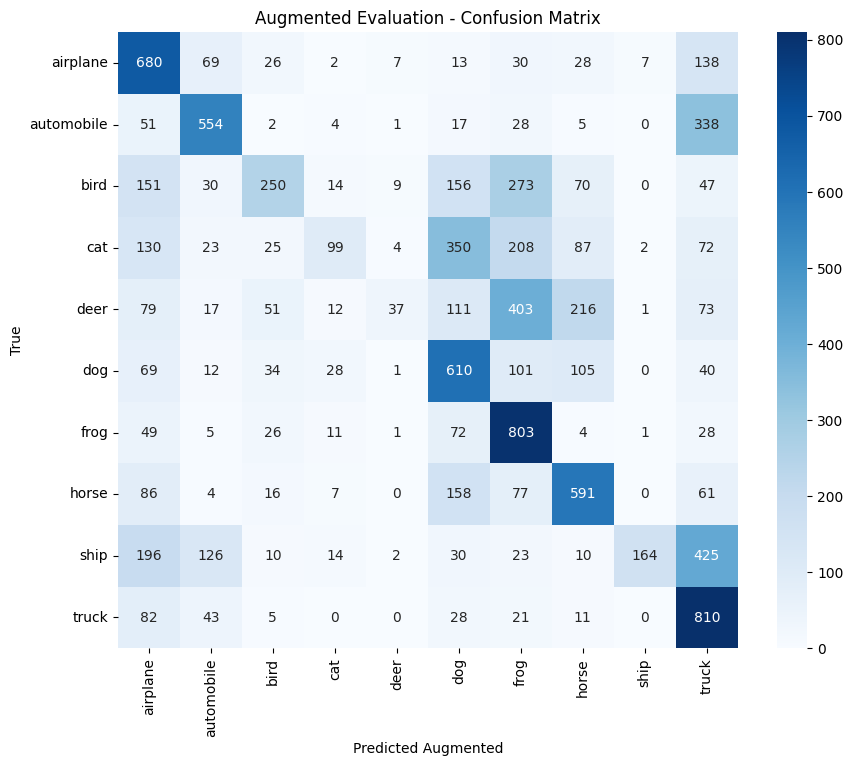

In [18]:
# Evealuating Augmented model then comparing with Base model
test_loss_aug, test_acc_aug = model_augmented.evaluate(x_test, y_test)
print(f"Test Aumented accuracy: {test_acc_aug:.4f}")

predictions_aug = model_augmented.predict(x_test)
predicted_classes_aug = np.argmax(predictions_aug, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(true_classes, predicted_classes_aug, target_names=list(classes.values())))


# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes_aug)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(classes.values()), yticklabels=list(classes.values()))
plt.xlabel('Predicted Augmented')
plt.ylabel('True')
plt.title('Augmented Evaluation - Confusion Matrix')

plt.savefig('figures/confusion_matrix_augmented.png')

baseline_metrics_augmented = {
    'test_accuracy_aug': test_acc_aug,
    'test_loss_aug': test_loss_aug,
    'classification_report_aug': classification_report(true_classes, predicted_classes_aug, target_names=list(classes.values()), output_dict=True)    
}